In [37]:
import psycopg2
from dataclasses import dataclass
import matplotlib.pyplot as plt
import networkx as nx
from pygraphviz import *

In [40]:
DB = "northwind_map"

In [41]:
conn = psycopg2.connect("dbname={} user=postgres password=password".format(DB))
cursor = conn.cursor()

In [4]:
@dataclass
class Attr:
    name: str
    data_type: str
    nullable: bool
        
@dataclass
class FK:
    source_attr_name: str
    target_table: str
    target_attr_name: str

In [5]:
class RelationalSchema:
    
    def __init__(self, tables):
        self.tables = tables

In [6]:
class Table:
    def __init__(self, name):
        self.name = name
        self.attr = []
        self.fk = []
        self.pk = set()
        self.is_referenced = False
        self.tuples = []
        
    def add_attr(self, attr):
        self.attr.append(attr)
        
    def add_fk(self, source_attribute, target_table_name, target_attribute):
        self.fk.append(FK(source_attribute, target_table_name, target_attribute))
        
    def add_pk(self, attr):
        self.pk.add(attr)
        
    def is_m2m(self):
        if self.is_referenced:
            return False
        
        refcnt = 0
        c = set()
        for fk in self.fk:
            if fk.source_attr_name not in self.pk:
                return False
            if fk.target_table not in c:
                c.add(target_table)
                refcnt += 1
        if refcnt != 2:
            return False
        
        return True
    
    def extract_tables(self):
        if not self.is_m2m():
            raise RuntimeError("exctracting edges is possible only for m2m tables")
            
        targets = []
        for fk in self.fk:
            target_table = fk.target_table
            targets.append(target_table)
            
        return sorted(targets) 

In [7]:
class GraphSchema:
    
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

In [8]:
class NodeClass:
    def __init__(self, label, nodes, attr, pk):
        self.label = label
        self.nodes = nodes
        self.attr = attr
        self.pk = pk
    

class Node:
    def __init__(self, vals, pk):
        self.vals = vals

        
class Edge:
    def __init__(self, label, source, target, attr=[], vals=[]):
        self.label = label
        self.source = source
        self.target = target
        self.attr = []

In [9]:
# process tables

In [10]:
tables = {}

In [49]:
cursor.execute("select count(*) from suppliers;")

In [50]:
cursor.fetchall()[0][0]

29

In [11]:
cursor.execute("""
        select distinct table_name
        from information_schema.columns
        where table_catalog = '{}' and table_schema = 'public';
""".format(DB))

table_names = list(map(lambda x: x[0], cursor.fetchall()))

table_names

['suppliers',
 'customer_demographics',
 'territories',
 'shippers',
 'orders',
 'customer_customer_demo',
 'order_details',
 'employees',
 'categories',
 'employee_territories',
 'customers',
 'products',
 'region',
 'us_states']

In [12]:
q_tpl = """
    select column_name, data_type, is_nullable
    from information_schema.columns
    where table_catalog = '{}' and table_schema = 'public' and table_name = '{}';
"""


for table_name in table_names:
    q = q_tpl.format(DB, table_name)
    cursor.execute(q)
    
    table = Table(table_name)
    for column_name, data_type, is_nullable in cursor.fetchall():
        is_nullable = True if is_nullable == "YES" else False
        attr = Attr(column_name, data_type, is_nullable)
        table.add_attr(attr)
        
    tables[table_name] = table

In [13]:
# process foreign keys

In [14]:
cursor.execute(
"""
    SELECT
        tc.table_name, 
        kcu.column_name, 
        ccu.table_name AS foreign_table_name,
        ccu.column_name AS foreign_column_name 
    FROM 
        information_schema.table_constraints AS tc 
        JOIN information_schema.key_column_usage AS kcu
          ON tc.constraint_name = kcu.constraint_name
          AND tc.table_schema = kcu.table_schema
        JOIN information_schema.constraint_column_usage AS ccu
          ON ccu.constraint_name = tc.constraint_name
          AND ccu.table_schema = tc.table_schema
    WHERE tc.constraint_type = 'FOREIGN KEY' AND tc.table_name in {};
""".format(tuple(tables.keys()))
)


for source_table_name, source_attribute, target_table_name, target_attribute in cursor.fetchall():
    source_table = tables[source_table_name]
    target_table = tables[target_table_name]
    target_table.is_referenced = True
    source_table.add_fk(source_attribute, target_table_name, target_attribute)

In [15]:
# process primary keys

In [16]:
cursor.execute("""
    SELECT c.column_name, tc.table_name
    FROM information_schema.table_constraints tc 
    JOIN information_schema.constraint_column_usage AS ccu USING (constraint_schema, constraint_name) 
    JOIN information_schema.columns AS c ON c.table_schema = tc.constraint_schema
      AND tc.table_name = c.table_name AND ccu.column_name = c.column_name
    WHERE constraint_type = 'PRIMARY KEY' and tc.table_name in {};
""".format(tuple(tables.keys()))
)


for column_name, table_name in cursor.fetchall():
    table = tables[table_name]
    table.add_pk(column_name)

In [17]:
# process tuples

In [18]:
q_t = """
    SELECT {}
    FROM {}
"""

for name, table in tables.items():
    q = q_t.format(", ".join(map(lambda x: x.name, table.attr)), name)
    cursor.execute(q)
    table.tuples = cursor.fetchall()

In [19]:
rel_schema = RelationalSchema(tables)

In [20]:
# main algorithm

In [21]:
class GraphSchema:
    
    def __init__(self, nodeClasses, edgeClasses):
        self.nodeClasses = nodeClasses
        self.edgeClasses = edgeClasses

In [22]:
class NodeClass:
    def __init__(self, label, attr, pk, nodes):
        self.label = label
        self.pk = pk
        self.nodes = nodes
        self.attr = attr

class Node:
    def __init__(self, label, attr, vals):
        self.vals = vals
        self.label = label
        self.attr = attr

class EdgeClass:
    def __init__(self, label, source, target, attr, edges):
        self.label = label
        self.source = source
        self.target = target
        self.attr = attr
        self.edges = edges
        
class Edge:
    def __init__(self, label, source, target, attr=[], vals=[]):
        self.label = label
        self.source = source
        self.target = target
        self.attr = attr
        self.vals = vals

In [23]:
from tqdm.notebook import trange, tqdm

In [24]:
def get_idx(attrs, fk, src=True):
    for i, a in enumerate(attrs):
        if src and a.name == fk.source_attr_name:
            return i, a
        elif not src and a.name == fk.target_attr_name:
            return i, a

def fk_from_node(node, fks):
    r = []
    for fk in fks:
        if fk.target_table == node.label:
            i, _ = get_idx(node.attr, fk)
            r.append(node.vals[i])
    return tuple(r)

def match_fk(n1, n2, tpl, tbl):
    for fk in tbl.fk:
        i, _ = get_idx(tbl.attr, fk)
        v1 = tpl[i]
        
        if fk.target_table == n1.label:
            i, _ = get_idx(n1.attr, fk, False)
            v2 = n1.vals[i]
            if v1 != v2:
                return False
            
        if fk.target_table == n2.label:
            i, _ = get_idx(n2.attr, fk, False)
            v2 = n2.vals[i]
            if v1 != v2:
                return False
    return True


def get_nodes(m2m_tbl, tpl, nodeClasses):
    src, dst = m2m_tbl.extract_tables()
    for nc in nodeClasses:
        if nc.label == src:
            src_nc = nc
        if nc.label == dst:
            dst_nc = nc
    for n1 in src_nc.nodes:
        for n2 in dst_nc.nodes:
            if n1.label == src and n2.label == dst and match_fk(n1, n2, tpl, m2m_tbl):
                return n1, n2

In [25]:
def get_nodes_fk(fk, src, nodeClasses):
    for nc in nodeClasses:
        if nc.label == src:
            src_nc = nc
        if nc.label == fk.target_table:
            dst_nc = nc
    
    for n1 in src_nc.nodes:
        for n2 in dst_nc.nodes:
            lhs_i, _ = get_idx(n1.attr, fk)
            rhs_i, _ = get_idx(n2.attr, fk, False)
            lhs = n1.vals[lhs_i]
            rhs = n2.vals[rhs_i]
            if lhs == rhs:
                yield n1, n2

In [26]:
def relational_to_graph(relSchema):
    nodeClasses = []
    edgeClasses = []
    edges = []
    G = nx.DiGraph()
    edge_labels = {}
    
    for name, table in relSchema.tables.items():
        if not table.is_m2m():
            t = [Node(name, table.attr, tpl) for tpl in table.tuples]
            nc = NodeClass(name, table.attr, table.pk, t)
            nodeClasses.append(nc)
            
            G.add_node(name)
    
    for name, table in relSchema.tables.items():
        if table.is_m2m():
            edges = []
            for tpl in table.tuples:
                table.extract_tables()
                src, dst = get_nodes(table, tpl, nodeClasses)
                edge = Edge(name, src, dst, table.attr, tpl)
                edges.append(edge)
            src, dst = table.extract_tables()
            ec = EdgeClass(name, src, dst, table.attr, edges)
            edgeClasses.append(ec)
            
            G.add_edge(src, dst)
            edge_labels[(src, dst)] = name

    for name, table in relSchema.tables.items():
        if not table.is_m2m():
            for fk in table.fk:
                dst_tbl = tables[fk.target_table]
                edges = []
                attrs = [fk.source_attr_name, fk.target_attr_name]
                i1, _ = get_idx(table.attr, fk)
                i2, _ = get_idx(dst_tbl.attr, fk, False)

                edges = []
                for n1, n2 in get_nodes_fk(fk, name, nodeClasses):
                    vals = [n1.vals[i1], n2.vals[i2]]
                    edge = Edge(fk.source_attr_name, n1, n2, attrs, vals)
                    edges.append(edge)
                ec = EdgeClass(fk.source_attr_name, name, fk.target_table, attrs, edges)
                edgeClasses.append(ec)
                
                G.add_edge(name, fk.target_table)
                edge_labels[(name, fk.target_table)] = fk.target_attr_name
                
    return GraphSchema(nodeClasses, edgeClasses), G, edge_labels

In [27]:
graphSchema, G, edge_labels = relational_to_graph(rel_schema)

In [28]:
def graph_to_relational(graphSchema):
    tables = {}
    
    for nc in graphSchema.nodeClasses:
        table = Table(nc.label)
        table.attr = nc.attr
        table.pk = nc.pk
        tuples = [node.vals for node in nc.nodes]
        table.tuples = tuples
        tables[nc.label] = table
        
    for ec in graphSchema.edgeClasses:
        if ec.label in ['customer_customer_demo', 'order_details', 'employee_territories']:
            table = Table(ec.label)
            table.attr = ec.attr
            table.tuples = [edge.vals for edge in ec.edges]
            tables[ec.label] = table
        elif ec.source == ec.target:
            src_tbl = tables[ec.source]
            dst_tbl = tables[ec.target]
            
            for fk in src_tbl.fk:
                if fk.target_table == ec.target:
                    src_tbl.add_fk(fk.source_attr_name, ec.target, fk.target_attr_name)
            src_attr = list(set(map(lambda x: x.name, src_tbl.attr)).intersection(set(ec.attr)))[0]
            dst_attr = list(set(map(lambda x: x.name, dst_tbl.attr)).intersection(set(ec.attr)))[1]
            src_tbl.add_fk(ec.label, ec.target, next(iter(src_tbl.pk)))
            
        elif ec.source != ec.target:
            src_tbl = tables[ec.source]
            dst_tbl = tables[ec.target]
            src_attr = list(set(map(lambda x: x.name, src_tbl.attr)).intersection(set(ec.attr)))[0]
            dst_attr = list(set(map(lambda x: x.name, dst_tbl.attr)).intersection(set(ec.attr)))[0]
            src_tbl.add_fk(src_attr, ec.target, dst_attr)
    
    return tables

In [34]:
for e in graphSchema.edgeClasses:
    print(e.label)

customer_customer_demo
order_details
employee_territories
region_id
customer_id
employee_id
ship_via
reports_to
category_id
supplier_id


In [37]:
new_tables = graph_to_relational(graphSchema)

In [38]:
new_tables

{'suppliers': <__main__.Table at 0x12680db50>,
 'customer_demographics': <__main__.Table at 0x12680dbb0>,
 'territories': <__main__.Table at 0x12680dc70>,
 'shippers': <__main__.Table at 0x12680da90>,
 'orders': <__main__.Table at 0x12680da60>,
 'employees': <__main__.Table at 0x12680dac0>,
 'categories': <__main__.Table at 0x12680dd30>,
 'customers': <__main__.Table at 0x12680da30>,
 'products': <__main__.Table at 0x12680dcd0>,
 'region': <__main__.Table at 0x12680d9a0>,
 'us_states': <__main__.Table at 0x12680d8e0>,
 'customer_customer_demo': <__main__.Table at 0x12680d940>,
 'order_details': <__main__.Table at 0x12680d910>,
 'employee_territories': <__main__.Table at 0x12680d8b0>}

In [39]:
for t in graphSchema.edgeClasses:
    if t.source == t.target:
        break

In [40]:
src_tbl = tables[t.source]
dst_tbl = tables[t.target]

In [41]:
src_tbl.fk

[FK(source_attr_name='reports_to', target_table='employees', target_attr_name='employee_id')]

In [42]:
tables["employees"].fk

[FK(source_attr_name='reports_to', target_table='employees', target_attr_name='employee_id')]

In [97]:
src_tbl.fk

[FK(source_attr_name='category_id', target_table='categories', target_attr_name='category_id'),
 FK(source_attr_name='supplier_id', target_table='suppliers', target_attr_name='supplier_id')]

In [86]:
new_tables[table_name].fk

[FK(source_attr_name='category_id', target_table='categories', target_attr_name='category_id'),
 FK(source_attr_name='supplier_id', target_table='suppliers', target_attr_name='supplier_id')]

In [89]:
table_name

'employees'

In [51]:
new_tables[table_name].fk

[]

In [174]:
new_tables[table_name].fk,tables[table_name].fk

([FK(source_attr_name='reports_to', target_table='employees', target_attr_name='employee_id')],
 [FK(source_attr_name='reports_to', target_table='employees', target_attr_name='employee_id')])

In [43]:
table_name = 'categories'

for table_name in ['products', 'suppliers', 'categories', 'shippers', 'customers', 'orders', 'territories', 'region']:
    assert new_tables[table_name].attr == tables[table_name].attr, f"tuple sets are not equal!, {table_name}"
    assert new_tables[table_name].pk == tables[table_name].pk, f"primary keys are not equal!, {table_name}"
    assert new_tables[table_name].fk == tables[table_name].fk, f"foreign keys are not equal!, {table_name}"
    assert new_tables[table_name].tuples == tables[table_name].tuples, f"tuple sets are not equal!, {table_name}"
    
for table_name in ['order_details', 'customer_customer_demo', 'employee_territories']:
    assert new_tables[table_name].attr == tables[table_name].attr, f"tuple sets are not equal!, {table_name}"
#    assert new_tables[table_name].pk == tables[table_name].pk, f"primary keys are not equal!, {table_name}"
#    assert new_tables[table_name].fk == tables[table_name].fk, f"foreign keys are not equal!, {table_name}"
    assert new_tables[table_name].tuples == tables[table_name].tuples, f"tuple sets are not equal!, {table_name}"
    
for table_name in ['employees']:
    assert new_tables[table_name].attr == tables[table_name].attr, f"tuple sets are not equal!, {table_name}"
    assert new_tables[table_name].pk == tables[table_name].pk, f"primary keys are not equal!, {table_name}"
    assert new_tables[table_name].fk == tables[table_name].fk, f"foreign keys are not equal!, {table_name}"
    assert new_tables[table_name].tuples == tables[table_name].tuples, f"tuple sets are not equal!, {table_name}"

In [ ]:
G = nx.DiGraph()
edge_labels = {}

nodeClasses = []
edges = []
edgeClasses = []

for name, table in tables.items():
    if not table.is_m2m():
        t = []
        for tpl in table.tuples:
            node = Node(name, table.attr, tpl)
            t.append(node)
        nc = NodeClass(name, table.attr, table.pk, t)
        nodeClasses.append(nc)
        
        G.add_node(name)

for name, table in tables.items():
    if table.is_m2m():
        edges = []
        for tpl in table.tuples:
            src, dst = get_nodes(table, tpl, nodeClasses)
            edge = Edge(name, src, dst, table.attr, tpl)
            edges.append(edge)
        
        src, dst = table.extract_tables()
        ex = EdgeClass(name, src, dst, table.attr, edges)
        
        G.add_edge(src, dst)
        edge_labels[(src, dst)] = name
        
for name, table in tables.items():
    if not table.is_m2m():
        for fk in table.fk:
            edges = []
            
            G.add_edge(name, fk.target_table)
            
            if name != 'employees':
                edge_labels[(name, fk.target_table)] = name + "-to-" + fk.target_table

graph_schema = GraphSchema(nodes, edges)

In [ ]:
graph_schema

{('customer_demographics',
  'customers'): Text(-1.1428571428571428, -0.21428571428571427, 'customer_customer_demo'),
 ('orders',
  'products'): Text(1.4107142857142856, -0.4107142857142857, 'order_details'),
 ('employees',
  'territories'): Text(-0.25892857142857145, 0.4732142857142857, 'employee_territories'),
 ('territories', 'region'): Text(-0.5535714285714286, 0.375, 'region_id'),
 ('orders', 'customers'): Text(-0.0625, -0.11607142857142856, 'customer_id'),
 ('orders',
  'employees'): Text(0.3303571428571428, 0.08035714285714286, 'employee_id'),
 ('orders',
  'shippers'): Text(0.42857142857142855, 0.17857142857142855, 'shipper_id'),
 ('employees', 'employees'): Text(-0.16071428571428575, 0.375, 'employee_id'),
 ('products',
  'categories'): Text(1.6071428571428572, -0.21428571428571425, 'category_id'),
 ('products',
  'suppliers'): Text(0.2321428571428571, -0.6071428571428571, 'supplier_id')}

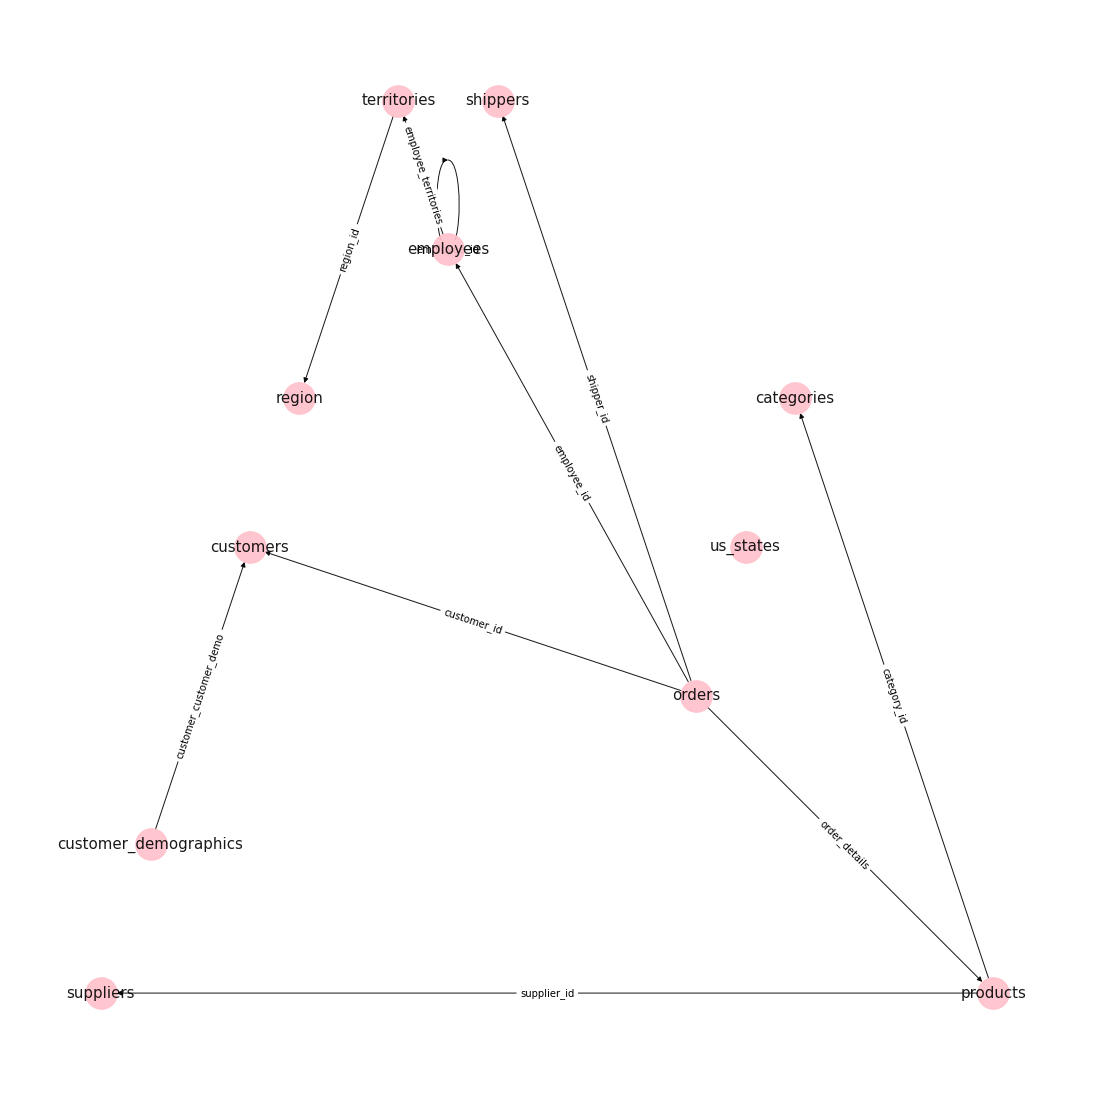

In [183]:
pos = nx.planar_layout(G, scale=2)
plt.figure(figsize=(15, 15))    
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=1000,node_color='pink',alpha=0.9,\
labels={node:node for node in G.nodes()}, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

In [51]:
STR_TYPES = {
    'character varying',
    'text',
    'bpchar',
    'character',
    'bytea',
    'date'
}

In [52]:
create_node_tpl = """CREATE (:{} {{{}}});"""


def format_attrs(attr, values):
    pairs = []
    for a, v in zip(attr, values):
        if v is None:
            continue
        
        if a.data_type in STR_TYPES:
            v = '"{}"'.format(v)
        else:
            v = '{}'.format(v)
        payload = str(a.name) + ": " + v
        pairs.append(payload)
        
    payload = ", ".join(pairs)
    return payload


def generate_neo4j_inserts(table):
    inserts = []
    
    for row in table.tuples:
        payload = format_attrs(table.attr, row)
        q = create_node_tpl.format(table.name, payload)
        inserts.append(q)
        
    return inserts


def get_idx(attrs, fk):
    for i, a in enumerate(attrs):
        if a.name == fk.source_attr_name:
            return i, a

In [53]:
edge_w_attr_creation_tpl = """
    MATCH (a:{0}), (b:{1})
    WHERE a.{2} = {3} AND b.{4} = {5}
    CREATE (a)-[:{6}]->(b)
"""

drop_q = """MATCH (n) DETACH DELETE n;"""

edge_creation_tpl = """MATCH (a:{0}), (b:{1}) WHERE a.{2} = b.{3} CREATE (a)-[:{4}]->(b);"""
edge_w_attr_creation_tpl = """MATCH (a:{0}), (b:{1}) WHERE a.{2} = {3} AND b.{4} = {5} CREATE (a)-[:{6} {{{7}}}]->(b);"""


In [54]:
pk_constraint_q_tpl = "CREATE CONSTRAINT ON (node:{}) ASSERT node.{} IS UNIQUE;"

In [66]:
drop_constraints_q = "CALL apoc.schema.assert({}, {});"

In [61]:
table = tables["suppliers"]

In [62]:
pk = list(table.pk)[0]
pk_constraint_q = pk_constraint_q_tpl.format(table.name, pk)

In [63]:
pk_constraint_q

'CREATE CONSTRAINT ON (node:suppliers) ASSERT node.supplier_id IS UNIQUE;'

In [36]:
for k, v in tables.items():
    print(k, v.is_m2m(), v.fk, v.pk)

suppliers False [] {'supplier_id'}
customer_demographics False [] {'customer_type_id'}
territories False [FK(source_attr_name='region_id', target_table='region', target_attr_name='region_id')] {'territory_id'}
shippers False [] {'shipper_id'}
orders False [FK(source_attr_name='customer_id', target_table='customers', target_attr_name='customer_id'), FK(source_attr_name='employee_id', target_table='employees', target_attr_name='employee_id'), FK(source_attr_name='ship_via', target_table='shippers', target_attr_name='shipper_id')] {'order_id'}
customer_customer_demo True [FK(source_attr_name='customer_type_id', target_table='customer_demographics', target_attr_name='customer_type_id'), FK(source_attr_name='customer_id', target_table='customers', target_attr_name='customer_id')] {'customer_type_id', 'customer_id'}
order_details True [FK(source_attr_name='product_id', target_table='products', target_attr_name='product_id'), FK(source_attr_name='order_id', target_table='orders', target_attr_

In [34]:
v.name

'us_states'

In [67]:

with open("/Users/a.palagashvili/coursework/neo4j/queries/tmp.cypher", "w") as out:
    out.write(drop_q + "\n\n")
    out.write(drop_constraints_q + "\n\n")
    
    for _, table in tables.items():
        if not table.is_m2m():
            inserts = generate_neo4j_inserts(table)
            for line in inserts:
                out.write(line + "\n")

            pk = list(table.pk)[0]
            pk_constraint_q = pk_constraint_q_tpl.format(table.name, pk)

            out.write(pk_constraint_q + "\n")
                
            out.write("\n\n")
            
    for _, table in tables.items():
        if not table.is_m2m():
            for fk in table.fk:
                edge_creation_q = edge_creation_tpl.format(
                    table.name, 
                    fk.target_table,
                    fk.source_attr_name,
                    fk.target_attr_name,
                    fk.source_attr_name,
                )
                
                out.write(edge_creation_q + "\n")

                
    for _, table in tables.items():
        for row in table.tuples:
            if table.is_m2m():
                fk1, fk2 = table.fk
                fk1_idx, lhs_a = get_idx(table.attr, fk1)
                fk2_idx, rhs_a = get_idx(table.attr, fk2)

                lhs_val = row[fk1_idx]
                rhs_val = row[fk2_idx]

                if lhs_a.data_type in STR_TYPES:
                    lhs_val = '"{}"'.format(lhs_val)

                if rhs_a.data_type in STR_TYPES:
                    rhs_val = '"{}"'.format(rhs_val)

                q = edge_w_attr_creation_tpl.format(
                    fk1.target_table,
                    fk2.target_table,
                    fk1.target_attr_name,
                    lhs_val,
                    fk2.target_attr_name,
                    rhs_val,
                    table.name,
                    format_attrs(table.attr, row)
                )
                
                out.write(q + "\n")
        out.write("\n\n")

In [1032]:
def get_idx(attrs, fk):
    for i, a in enumerate(attrs):
        if a.name == fk.source_attr_name:
            return i, a

In [1035]:
lhs_a

Attr(name='territory_id', data_type='character varying', nullable=False)

In [1038]:
q

'MATCH (a:territories), (b:employees) WHERE a.territory_id = "55439" AND b.employee_id = 9 CREATE (a)-[:employee_territories {employee_id: 9, territory_id: "55439"}]->(b);'

In [406]:
import re

In [809]:
drop_q = """MATCH (n) DETACH DELETE n"""

In [810]:
drop_q

'MATCH (n) DETACH DELETE n'

In [781]:
def format_attrs(attr, values):
    pairs = []
    for a, v in zip(attr, values):
        if v == "NULL":
            continue
        
        if a.data_type in STR_TYPES:
            v = '"{}"'.format(v)
        payload = str(a.name) + ": " + v
        pairs.append(payload)
        
    payload = ", ".join(pairs)
    return payload

In [816]:
create_node_tpl = """CREATE (:{} {{{}}});"""

In [817]:
insertions = []
node_creations = [drop_q, "\n\n"]
pattern = "VALUES (.+?);"

p = None
for line in open("/Users/a.palagashvili/coursework/psql/queries/migrations.sql"):
    line = line.strip()
    if 'INSERT' in line:
        table_name = line.split(" ")[2]
        
        if p is not None and p != table_name:
            node_creations.append("\n\n")
        p = table_name
        
        table = tables[table_name]
        
        if table.is_m2m():
            continue
        
        attr = table.attr

        txt = re.search(pattern, line).group(0)[8:-2]
        values = [val for val in csv.reader([txt], skipinitialspace=True, quotechar="'")][0]
        payload = format_attrs(attr, values)
        node_creations.append(create_node_tpl.format(table_name, payload))
        insertions.append(line)

In [818]:
with open("/Users/a.palagashvili/coursework/neo4j/queries/migrations.cypher", "w") as out:
    for line in node_creations: 
        out.write(line + "\n")

In [702]:
node_creations

['\nCREATE (n:categories {category_id: 1, category_name: "Beverages", description: "Soft drinks, coffees, teas, beers, and ales", picture: \\x});\n']

In [651]:
values[3]

'\\x'

In [684]:
values = re.search(pattern, line).group(0)[1:-1]

In [685]:
values

"1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x'"

In [666]:
from io import StringIO

In [686]:
values

"1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x'"

In [690]:
values

"1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x'"

In [687]:
vals = []
val_io = StringIO(values)
for val in csv.reader(val_io, skipinitialspace=True, quotechar="'", quoting=csv.QUOTE_ALL):
    print(val)
    vals.append(val)

['1', 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x']


In [639]:
import pandas as pd

In [688]:
val

['1', 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x']

In [69]:
for _, table in tables.items():
    print(table.name, table.pk)

suppliers {'supplier_id'}
customer_demographics {'customer_type_id'}
territories {'territory_id'}
shippers {'shipper_id'}
orders {'order_id'}
customer_customer_demo {'customer_type_id', 'customer_id'}
order_details {'product_id', 'order_id'}
employees {'employee_id'}
categories {'category_id'}
employee_territories {'employee_id', 'territory_id'}
customers {'customer_id'}
products {'product_id'}
region {'region_id'}
us_states {'state_id'}


In [608]:
node_creations

["\nCREATE (n:categories {category_id: 1, category_name:  'Beverages', description:  'Soft drinks, picture:  coffees});\n",
 "\nCREATE (n:categories {category_id: 2, category_name:  'Condiments', description:  'Sweet and savory sauces, picture:  relishes});\n",
 "\nCREATE (n:categories {category_id: 3, category_name:  'Confections', description:  'Desserts, picture:  candies});\n",
 "\nCREATE (n:categories {category_id: 4, category_name:  'Dairy Products', description:  'Cheeses', picture:  '\\x'});\n",
 "\nCREATE (n:categories {category_id: 5, category_name:  'Grains/Cereals', description:  'Breads, picture:  crackers});\n",
 "\nCREATE (n:categories {category_id: 6, category_name:  'Meat/Poultry', description:  'Prepared meats', picture:  '\\x'});\n",
 "\nCREATE (n:categories {category_id: 7, category_name:  'Produce', description:  'Dried fruit and bean curd', picture:  '\\x'});\n",
 "\nCREATE (n:categories {category_id: 8, category_name:  'Seafood', description:  'Seaweed and fish',

In [606]:
payload

"category_id: 8, category_name:  'Seafood', description:  'Seaweed and fish', picture:  '\\x'"

In [605]:
values

['8', " 'Seafood'", " 'Seaweed and fish'", " '\\x'"]

In [596]:
import csv

In [585]:

from csv import reader

In [591]:
val[1].strip()

"'Seafood'"

In [593]:
val[3]

" '\\x'"

In [602]:
reader([values])

0

In [597]:
for val in csv.reader([values], skipinitialspace=False,delimiter=',', quoting=csv.QUOTE_NONE):
    print(val)

['8', " 'Seafood'", " 'Seaweed and fish'", " '\\x'"]


In [584]:
re.split(r",(?=')", values)

["8, 'Seafood', 'Seaweed and fish', '\\x'"]

In [581]:
for a, v in zip(attr, values):
    print(a, v)

Attr(name='category_id', data_type='smallint', nullable=False) 8, 'Seafood', 'Seaweed and fish', '\x'


In [579]:
attr

[Attr(name='category_id', data_type='smallint', nullable=False),
 Attr(name='category_name', data_type='character varying', nullable=False),
 Attr(name='description', data_type='text', nullable=True),
 Attr(name='picture', data_type='bytea', nullable=True)]

In [576]:
node_creations

["\nCREATE (n:categories {category_id: 1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 2, 'Condiments', 'Sweet and savory sauces, relishes, spreads, and seasonings', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 3, 'Confections', 'Desserts, candies, and sweet breads', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 4, 'Dairy Products', 'Cheeses', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 5, 'Grains/Cereals', 'Breads, crackers, pasta, and cereal', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 6, 'Meat/Poultry', 'Prepared meats', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 7, 'Produce', 'Dried fruit and bean curd', '\\x'});\n",
 "\nCREATE (n:categories {category_id: 8, 'Seafood', 'Seaweed and fish', '\\x'});\n"]

In [480]:
values

"51, 'Wyoming', 'WY', 'west'"

In [479]:
attr

{'state_id': Attr(name='state_id', data_type='smallint', nullable=False),
 'state_name': Attr(name='state_name', data_type='character varying', nullable=True),
 'state_abbr': Attr(name='state_abbr', data_type='character varying', nullable=True),
 'state_region': Attr(name='state_region', data_type='character varying', nullable=True)}

In [431]:
table_name

'us_states'

In [475]:
values

"51, 'Wyoming', 'WY', 'west'"

In [405]:
line

'--'

In [411]:
e

"INSERT INTO categories VALUES (1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x');"

In [425]:
table_name = e.split(" ")[2]

In [428]:
table_name

'us_states'

In [407]:
e = insertions[0]

In [419]:
pattern = "\(.+?\)"

In [422]:
found = re.search(pattern, e).group(0)[1:-1]

In [423]:
found

"1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales', '\\x'"